# Black Scholes
**calculate value of option**

In [11]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline
from pprint import pprint

import myalpha
api_key_alpha = myalpha.secret['api_key_alpha']

print(api_key_alpha)

77K8XPSR3XWWZJ80


# Update CSV files
* if your csv is out-dated (less than 100days)then you can update it by using update_csv
* this will retrieve the last 100days of you symbols from alpha_vantage and append the ones missing in 
* your csv - it will write back the csv file with the appended registries 

>    import myalpha_util as myau
    symbol_list=['PG','SPY']
    myau.update_csv(symbol_list,api_key_alpha)
>

In [10]:
'''
import myalpha_util as myau
symbol_list=['PG','SPY']
myau.update_csv(symbol_list,api_key_alpha)
'''


processing symbol: PG
last stock-date available from alpha_vantage: 2020-04-24
number of entries we need to append to csv: 88
retrieving head data from csv
the final csv to be updated

processing symbol: SPY
last stock-date available from alpha_vantage: 2020-04-24
number of entries we need to append to csv: 88
retrieving head data from csv
the final csv to be updated


In [12]:
#compose a n-column portfolio with the daily price just as in the udemy course
#you need to have imported the csv files first - just as described earlier
import myalpha_util as myau
symbol_list=['PG']
start='2007-01-01'
end='2017-03-21'
#usecols=['timestamp','adjusted_close', 'volume']
pf_data=myau.compose_portfolio(symbol_list,start,end)
pf_data.info()
pf_data.size
print("_____________________________")
pf_data.head(1)
pf_data.tail(1)
print("_____________________________")
pf_data.describe()
len(pf_data.index)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2572 entries, 2007-01-03 to 2017-03-21
Data columns (total 1 columns):
PG    2572 non-null float64
dtypes: float64(1)
memory usage: 40.2 KB


2572

_____________________________


,PG
timestamp,
2007-01-03,43.3759


,PG
timestamp,
2017-03-21,83.1981


_____________________________


,PG
count,2572.000000
mean,55.775562
std,12.712640
min,31.262500
25%,45.548325
50%,50.405750
75%,67.203250
max,83.636100


2572

In [13]:
log_returns=np.log(pf_data / pf_data.shift(1))
log_returns.head(1)
log_returns.tail(1)
np.shape(log_returns)

,PG
timestamp,
2007-01-03,NaN


,PG
timestamp,
2017-03-21,-0.000329


(2572, 1)

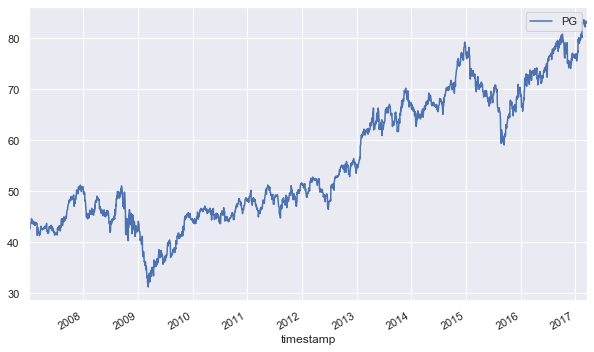

In [14]:
import seaborn as sns
sns.set()

pf_data.plot(figsize=(10,6))

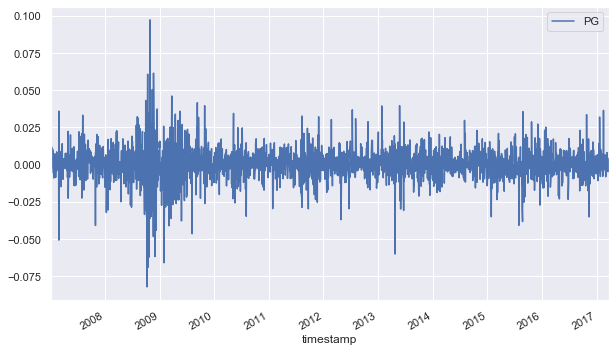

In [15]:
#we plot the returns and see that the returns are normally distributes and have a stable mean


log_returns.plot(figsize=(10,6))

$$
d_1 = \frac{\ln(\frac{S}{K}) + (r + \frac{stdev^2}{2})t}{s \cdot \sqrt{t}}
$$

$$
d_2 = d_1 - s \cdot \sqrt{t} = \frac{\ln(\frac{S}{K}) + (r - \frac{stdev^2}{2})t}{s \cdot \sqrt{t}}
$$

    
* **S stock price**
* **K strike price**
* **r risk free rate**
* **stdev -standard deviation**
* **T time horizon(years)**
    

In [16]:
def d1(S, K, r, stdev, T):
    return (np.log(S / K) + (r + stdev ** 2 / 2) * T) / (stdev * np.sqrt(T))
 
def d2(S, K, r, stdev, T):
    return (np.log(S / K) + (r - stdev ** 2 / 2) * T) / (stdev * np.sqrt(T))

def BSM(S, K, r, stdev, T):
        return (S * norm.cdf(d1(S, K, r, stdev, T))) - (K * np.exp(-r * T) * norm.cdf(d2(S, K, r, stdev, T)))

In [17]:
#cumulative distr.function - input is the standardised value (x-mue)/sigma
#for example for mue = x  ...x-mue is zero
norm.cdf(0)

0.5

In [18]:
norm.cdf(-0.25)

0.4012936743170763

$$
\textbf{C} = SN(d_1) - Ke^{-rt}N(d_2) 
$$

In [19]:
def BSM(S, K, r, stdev, T):
        return (S * norm.cdf(d1(S, K, r, stdev, T))) - (K * np.exp(-r * T) * norm.cdf(d2(S, K, r, stdev, T)))

In [31]:
#last stock price
S = pf_data.iloc[-1]
S
#S = 91.19

PG    83.1981
Name: 2017-03-21 00:00:00, dtype: float64

In [32]:
#annual standard deviation - so T will be 1 year
stdev = log_returns.std() * 250 ** 0.5
stdev

PG    0.176582
dtype: float64

In [33]:
r = 0.025
K = 110.0
T = 1
#time horizon is 1 year if T=1

In [34]:
d1(S, K, r,stdev, T)

PG   -1.351584
dtype: float64

In [35]:
d2(S,K,r,stdev,T)

PG   -1.528166
dtype: float64

In [36]:
BSM(S,K,r,stdev,T)

PG    0.558402
Name: 2017-03-21 00:00:00, dtype: float64

## Euler discretization

### calculate future stock prices
**monte carlo simulation provides thousands of possible call option prices
then average the payoff and discount it back to today**

**the trick lies in how we are going to calculate the future prices
it will be another application of a Brownian Motion**

>
$$
S_t = S_{t-1} \cdot exp((r - 0.5 \cdot stdev^2) \cdot delta_t + stdev \cdot delta_t^{0.5} \cdot Z_t)
$$
    

stdeve of logreturns
delta - fixed time interval 
Z random component 
    


In [39]:
type(stdev)
#transfer series object to a numpy array
stdev = stdev.values
stdev

pandas.core.series.Series

array([0.17658194])

In [40]:
T = 1.0
t_intervals = 250
delta_t = T / t_intervals

iterations = 10000

In [41]:
Z = np.random.standard_normal((t_intervals + 1 , iterations))
S = np.zeros_like(Z)
S0 = pf_data.iloc[-1]
S[0]=S0

In [43]:
for t  in range(1, t_intervals +1 ):
    S[t]=S[t-1]*np.exp((r-0.5*stdev**2) *delta_t +stdev*delta_t**0.5*Z[t])

In [44]:
S

array([[83.1981    , 83.1981    , 83.1981    , ..., 83.1981    ,
        83.1981    , 83.1981    ],
       [82.952942  , 82.82250679, 85.11283739, ..., 84.2345925 ,
        84.23915622, 83.82333935],
       [83.20959493, 83.64642864, 86.09287898, ..., 85.04350647,
        84.43473612, 85.77133864],
       ...,
       [66.69236614, 96.88216569, 69.70562423, ..., 59.52883521,
        70.86431805, 78.23701217],
       [66.64185014, 96.85737631, 70.8332908 , ..., 59.74358223,
        71.1915867 , 77.66741745],
       [66.1491426 , 96.61428004, 70.59978956, ..., 59.40340794,
        71.08465738, 76.59059585]])

In [46]:
S.shape

(251, 10000)

<Figure size 720x432 with 0 Axes>

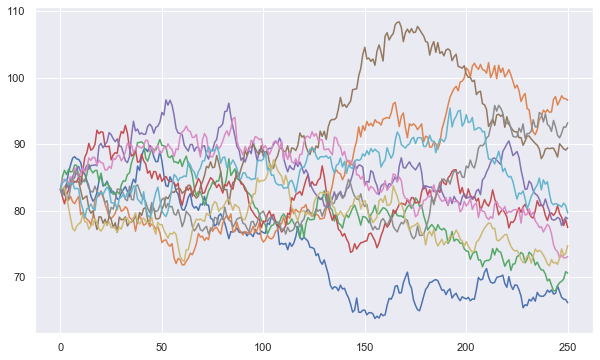

In [51]:
plt.figure(figsize=(10,6))
plt.plot(S[: , :10])
# solo visualiza los primeros 10 simulaciones de 250 dias cada uno

In [55]:
#buy if strike price is greater than stock price s-k>0
# s-k = payoff!
p = np.maximum(S[-1]-K,0)
p.shape

(10000,)

## discount the average payoff

$$
C = \frac{exp(-r \cdot T) \cdot \sum{p_i}}{iterations}
$$
    

In [56]:
C = np.exp(-r*T)*np.sum(p)/iterations
C

0.5014920949415064

**as you see the calculation is not that different from Black Scholes**